In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
import tensorboard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp

from photoz_utils import *
from DataMaker import *

2023-11-27 22:07:38.159107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 22:07:38.934630: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 256
EPOCHS = 100
GB_LIMIT = 10
Z_MAX = 4
LR = 0.0001

hparams = {
    'batch_size': BATCH_SIZE,
    'num_epochs': EPOCHS,
    'z_max': Z_MAX,
    'learning_rate': LR
}

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-11-27 22:07:41.479150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 22:07:41.565094: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 22:07:41.565355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
args_gen = {'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': True,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}

# TRAIN_PATH = f'/data/HSC_generated/HSC_generated_v1/step1/127x127/5x127x127_training.hdf5'
TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/127x127/5x127x127_training.hdf5'
VAL_PATH = f'/data/HSC_generated/HSC_generated_v1/step1/127x127/5x127x127_validation.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing.hdf5'
# TEST_PATH = f'/data/HSC_generated/HSC_generated_v1/step1/127x127/5x127x127_testing.hdf5'

In [14]:
train_gen = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
val_gen = HDF5ImageGenerator(src=VAL_PATH, **args_gen)
test_gen = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

In [6]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    loss = 1 - 1.0 / denominator
    return loss

In [7]:
input_ = Input(shape=(5,127,127))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(input_)
pool1 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool2)
pool3 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv3)
conv4 = Conv2D(256, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool3)
pool4 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv4)
conv5 = Conv2D(256, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool4)
pool5 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv5)
conv6 = Conv2D(512, kernel_size=(3, 3),activation='relu', padding='same', data_format='channels_first')(pool5)
conv7 = Conv2D(512, kernel_size=(3, 3),activation='relu', padding='same', data_format='channels_first')(conv6)
flatten = Flatten()(conv7)
dense1 = Dense(512, activation='tanh')(flatten)
dense2 = Dense(128, activation='tanh')(dense1)
dense3 = Dense(32, activation='tanh')(dense2)
output = Dense(1)(dense3)
model = Model(inputs=[input_], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 127, 127)]     0         
                                                                 
 conv2d (Conv2D)             (None, 32, 127, 127)      1472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 63, 63)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 63, 63)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 31, 31)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 31, 31)       73856 

In [8]:
model.compile(optimizer=Adam(learning_rate=hparams['learning_rate']), loss=calculate_loss, metrics='mse')

In [9]:
model.fit(train_gen, epochs=EPOCHS, shuffle=True, verbose=1, validation_data=val_gen)

Epoch 1/100


2023-11-27 22:07:43.194536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-27 22:07:44.911987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-11-27 22:07:45.086151: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-27 22:07:45.676413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-27 22:07:45.717219: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f23aebfa870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-27 22:07:45.717245: I tensorflo

800/800 [==============================] - ETA: 0s - loss: 0.2216 - mse: 0.1492

2023-11-27 22:18:04.270396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


800/800 [==============================] - 775s 962ms/step - loss: 0.2216 - mse: 0.1492 - val_loss: 0.4448 - val_mse: 0.2047
Epoch 2/100
800/800 [==============================] - 714s 893ms/step - loss: 0.1351 - mse: 0.0925 - val_loss: 0.4600 - val_mse: 0.2036
Epoch 3/100
800/800 [==============================] - 645s 806ms/step - loss: 0.1114 - mse: 0.0836 - val_loss: 0.4598 - val_mse: 0.2225
Epoch 4/100
800/800 [==============================] - 642s 803ms/step - loss: 0.0938 - mse: 0.0774 - val_loss: 0.4829 - val_mse: 0.2693
Epoch 5/100
800/800 [==============================] - 699s 875ms/step - loss: 0.0862 - mse: 0.0754 - val_loss: 0.5315 - val_mse: 0.3854
Epoch 6/100
800/800 [==============================] - 703s 879ms/step - loss: 0.0774 - mse: 0.0722 - val_loss: 0.4806 - val_mse: 0.2697
Epoch 7/100
800/800 [==============================] - 699s 873ms/step - loss: 0.0718 - mse: 0.0703 - val_loss: 0.4907 - val_mse: 0.2432
Epoch 8/100
800/800 [==============================] 

KeyboardInterrupt: 

In [15]:
pred = model.predict(test_gen)

2023-11-28 10:44:13.197767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


160/160 [==============================] - 126s 787ms/step


In [16]:
with h5py.File(TEST_PATH, 'r') as file:
    y_test = np.asarray(file['specz_redshift'][:])
    # oid_test = np.asarray(file['object_id'][:])

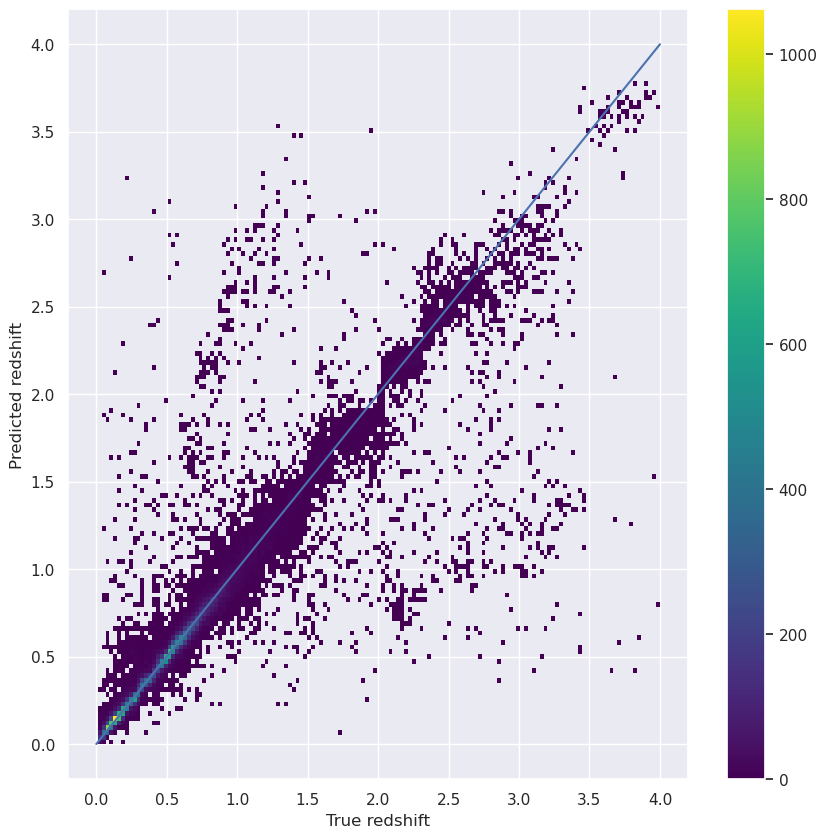

In [17]:
plot_predictions(np.ravel(pred), y_test)

In [ ]:
metrics = get_point_metrics(pd.Series(np.ravel(pred)), pd.Series(y_test), binned=False)

In [ ]:
metrics

In [ ]:
df = pd.DataFrame(pred, columns=['photoz'])
df['specz'] = pd.Series(y_test)
df['object_id'] = pd.Series(oid_test)
os.makedirs(f'/data2/predictions/{model_name}', exist_ok=True)
df.to_csv(f'/data2/predictions/{model_name}/testing_predictions.csv', index=False)
metrics.to_csv(f'/data2/predictions/{model_name}/testing_metrics.csv', index=False)